## Final Project: Prediksi Harga Saham Bank di Indonesia

**Karina Anggraeni - JCDSAH BSD** </br>
Dataset diambil dari aplikasi Neo HOTS (Mirae Asset Sekuritas)

Data harga saham bank yang digunakan dalam dataset ini adalah data terhadap bank swasta nasional, bank swasta asing, dan bank milik negara, yaitu:
- Bank Central Asia (BBCA) dan Bank Mega (MEGA) - swasta nasional
- Bank Woori Saudara (SDRA) dan MayBank (BNII) - swasta asing
- Bank Rakyat Indonesia (BRII) dan Bank Mandiri (BMRI) - negara

### [PART 2: Stock Price Prediction - BBCA]

### 4. Modeling and Evaluation

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import os
from statsmodels.tsa.stattools import adfuller
from IPython.core.debugger import set_trace
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.models import load_model

from IPython import display

import warnings
warnings.filterwarnings('ignore')

#### A. BBCA Stock Prediction

In [2]:
bbca = pd.read_csv('../Datasets/df_bbca.csv', index_col = 'Date')

In [3]:
bbca.head()

,Close
Date,
2016-01-02,13225
2016-01-03,13400
2016-01-04,13300
2016-01-06,13175
2016-01-07,13225


In [78]:
bbca.describe()

,Close
count,1211.00
mean,23058.88
std,6527.32
min,12750.00
25%,16550.00
50%,23375.00
75%,28862.50
max,34750.00


In [4]:
bbca_train_len = math.ceil(len(bbca)*0.8)
bbca_train_len

969

#### A.1. ARIMA Model

**ADF Stationary Test**

Augumented Dickey Fuller Test (ADF Test) digunakan untuk memeriksa stationer/ tidaknya suatu data. Test ini biasanya digunakan dalam ARIMA untuk time-series karena model ARIMA akan bekerja lebih baik pada data yang bersifat stationer.

In [5]:
bbca_adf = adfuller(bbca)

print(f'ADF Statistics: {bbca_adf[0]}')

if bbca_adf[1] > 0.05:
    print(f'p-value: {bbca_adf[1]}, data is stationary.')
else:
    print(f'p-value: {bbca_adf[1]}, data is non-stationary.')

ADF Statistics: -0.633522186458457
p-value: 0.8632260762177842, data is stationary.


Karena nilai p-value dari ADF Test terhadap BBCA melebihi 0.05 (p-value > 0.05), maka dapat disimpulkan data yang kita miliki tidak stationer.

**Manual Parameter Tuning**

Pada model ARIMA, terdapat 3 jenis parameter yang dibutuhkan ketika melakukan modeling, yaitu: </br>
- **p** menyatakan nilai variabel AR (Auto Regressive Variable/ Lag Variable) atau berapa banyak data periode sebelumnya yang akan digunakan dalam feature </br>
- **d** menyatakan nilai variabel I (Integrated Variable) atau berapa banyak diferensiasi yang perlu dilakukan agar data time-series menjadi stationer </br>
- **p** menyatakan nilai variabel MA (Moving Average Variable)

Nilai p, d, dan q dapat kita estimasi menggunakan plot ACF dan  PACF.

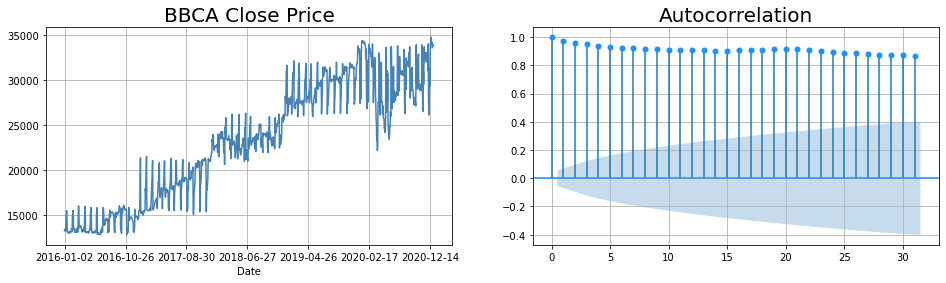

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,4))
bbca['Close'].plot(color = 'steelblue', ax = ax1)
ax1.set_title('BBCA Close Price', size = 20)
ax1.grid()

plot_acf(bbca['Close'], color = 'dodgerblue', ax = ax2)
ax2.set_title('Autocorrelation', size = 20)
ax2.grid()

plt.show()

Kita akan menentukan banyaknya diferensiasi yang diperlukan dengan menggunakan _ndiffs_ dari package pmdarima.

In [7]:
ndiffs(bbca['Close'], test = 'adf')

0

Karena nilai _ndiifs_ adalah 0, berarti data harga `Close` BBCA yang kita miliki tidak perlu didiferensiasi.

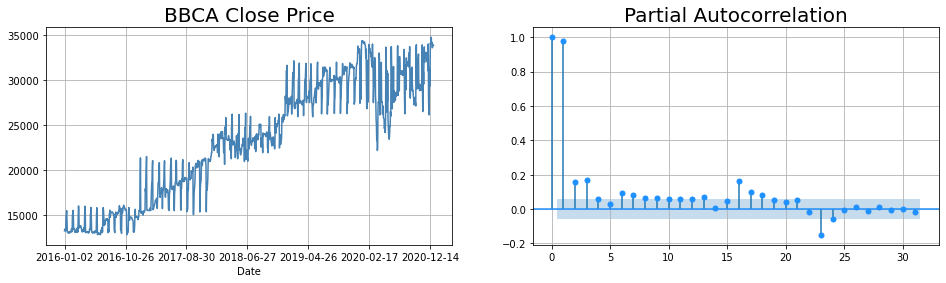

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,4))
bbca['Close'].plot(color = 'steelblue', ax = ax1)
ax1.set_title('BBCA Close Price', size = 20)
ax1.grid()

plot_pacf(bbca['Close'], color = 'dodgerblue', ax = ax2)
ax2.set_title('Partial Autocorrelation', size = 20)
ax2.grid()

plt.show()

Dari plot PACF, kita pilih nilai p = 1 (nilai yang melebihi area yang diarsir/ significance line) dan nilai q = 4 (nilai yang berada di dalam significance line).

Sehingga kita dapatkan **p = 1**, **d = 0**, dan **q = 4**.

**Train Test Split**

In [9]:
bbca_arima_train = bbca['Close'][:bbca_train_len]
bbca_arima_valid = bbca['Close'][bbca_train_len:]

**Model Fitting and Evaluation**

In [10]:
bbca_arima = ARIMA(bbca_arima_train, order = (1, 0, 4))
bbca_arima_result = bbca_arima.fit()

bbca_arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  969
Model:                 ARIMA(1, 0, 4)   Log Likelihood               -8080.334
Date:                Sun, 18 Apr 2021   AIC                          16174.668
Time:                        21:35:51   BIC                          16208.802
Sample:                             0   HQIC                         16187.661
                                - 969                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.13e+04   1.37e+04      1.553      0.120   -5586.552    4.82e+04
ar.L1          0.9998      0.001    897.286      0.000       0.998       1.002
ma.L1         -0.2855      0.029     -9.756      0.000      -0.343      -0.228
ma.L2         -0.1886      0.036     -5.197      0.000      -0.260      -0.117
ma.L3         -0.1693      0.036     -4.705      0.000      -0.240      -0.099
ma.L4         -0.1716      0.036     -4.774      0.000      -0.242      -0.101
sigma2      1.057e+06    760.863   1389.130      0.000    1.06e+06    1.06e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              1545.56
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                            -1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.23e+18. Standard errors may be unstable.
"""

In [11]:
steps = len(bbca_arima_valid)

fc = bbca_arima_result.forecast(steps)
fc_series = pd.DataFrame(fc)

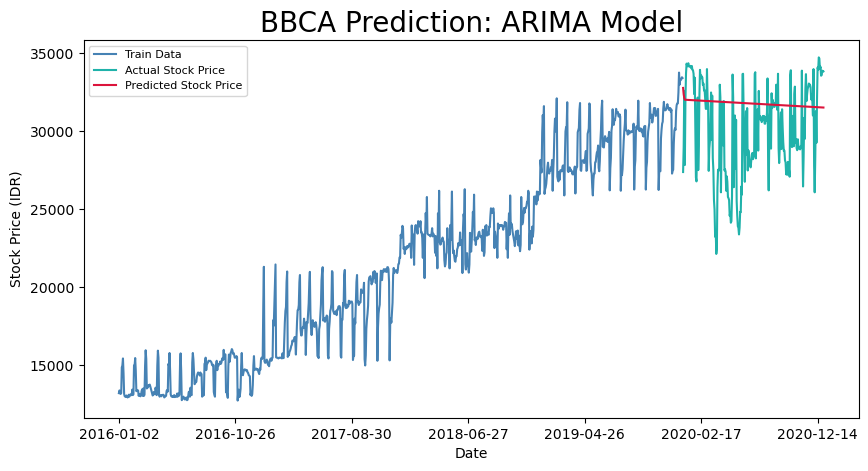

In [12]:
plt.figure(figsize = (10,5), dpi = 100)
plt.plot(bbca_arima_train, label = 'Train Data', color = 'steelblue')
plt.plot(bbca_arima_valid, label = 'Actual Stock Price', color = 'lightseagreen')
plt.plot(fc_series, label = 'Predicted Stock Price', color = 'crimson')
plt.title('BBCA Prediction: ARIMA Model', size = 20)
plt.xticks(ticks = [0, 200, 400, 600, 800, 1000, 1200])
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [13]:
mse = mean_squared_error(bbca_arima_valid, fc)
print(f'MSE: {mse}')
rmse = math.sqrt(mean_squared_error(bbca_arima_valid, fc))
print(f'RMSE: {rmse}')

MSE: 11567035.288686393
RMSE: 3401.034443913556


**Auto ARIMA Tuning**

In [14]:
model_autoARIMA = auto_arima(bbca_arima_train, start_p = 0, start_q = 0,
                      test = 'adf',       # use adftest to find optimal 'd'
                      max_p = 10, max_q = 10, # maximum p and q
                      m = 1,              # frequency of series
                      d = None,           # let model determine 'd'
                      seasonal = False,   # No Seasonality
                      start_P = 0, 
                      D = 0, 
                      trace = True,
                      error_action = 'ignore',  
                      suppress_warnings = True, 
                      stepwise = True)

print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22140.308, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=20886.952, Time=0.59 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16257.880, Time=0.51 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16280.231, Time=0.85 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16244.055, Time=0.76 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=1.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=16260.575, Time=1.58 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16207.470, Time=0.96 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=19696.941, Time=2.47 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=16241.719, Time=1.41 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=16174.166, Time=1.71 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=2.52 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=16210.239, Time=1.72 sec
 ARIMA(1,0,5)(0,0,0)[0]             :

In [15]:
bbca_arima_tuned = ARIMA(bbca_arima_train, order = (2, 0, 7))
bbca_arima_tuned_result = bbca_arima_tuned.fit()

bbca_arima_tuned_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  969
Model:                 ARIMA(2, 0, 7)   Log Likelihood               -8070.487
Date:                Sun, 18 Apr 2021   AIC                          16162.975
Time:                        21:37:05   BIC                          16216.614
Sample:                             0   HQIC                         16183.393
                                - 969                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.13e+04   9834.794      2.166      0.030    2026.120    4.06e+04
ar.L1          0.0438      0.045      0.973      0.331      -0.044       0.132
ar.L2          0.9557      0.045     21.194      0.000       0.867       1.044
ma.L1          0.6876      0.055     12.559      0.000       0.580       0.795
ma.L2         -0.4216      0.035    -11.970      0.000      -0.491      -0.353
ma.L3         -0.2731      0.046     -5.996      0.000      -0.362      -0.184
ma.L4         -0.2382      0.048     -4.957      0.000      -0.332      -0.144
ma.L5         -0.2137      0.049     -4.332      0.000      -0.310      -0.117
ma.L6         -0.1285      0.047     -2.759      0.006      -0.220      -0.037
ma.L7         -0.0637      0.040     -1.575      0.115      -0.143       0.016
sigma2      1.004e+06   2.86e+04     35.124      0.000    9.48e+05    1.06e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              1790.69
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                            -1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.95e+14. Standard errors may be unstable.
"""

In [16]:
steps = len(bbca_arima_valid)

fc_tuned = bbca_arima_tuned_result.forecast(steps, alpha = 0.05)
fc_series_tuned = pd.DataFrame(fc_tuned)

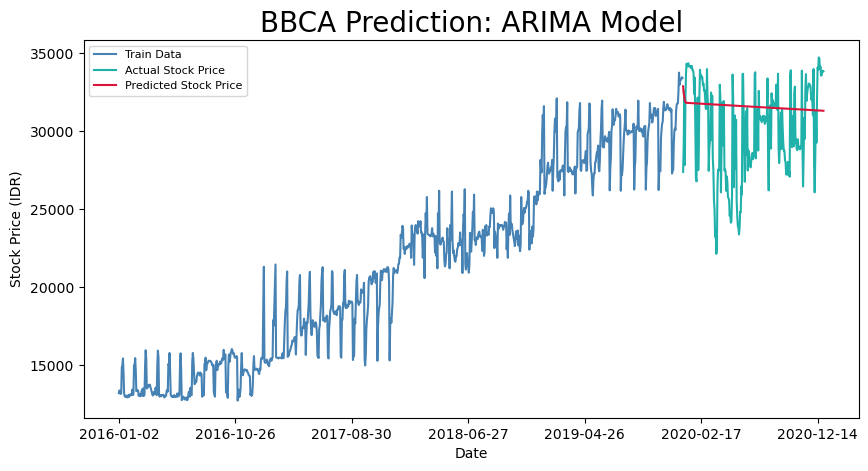

In [17]:
plt.figure(figsize = (10,5), dpi = 100)
plt.plot(bbca_arima_train, label = 'Train Data', color = 'steelblue')
plt.plot(bbca_arima_valid, label = 'Actual Stock Price', color = 'lightseagreen')
plt.plot(fc_series_tuned, label = 'Predicted Stock Price', color = 'crimson')
plt.title('BBCA Prediction: ARIMA Model', size = 20)
plt.xticks(ticks = [0, 200, 400, 600, 800, 1000, 1200])
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper left', fontsize = 8)

plt.savefig('BBCA ARIMA.png')
plt.show()

In [18]:
mse_tuned = mean_squared_error(bbca_arima_valid, fc_tuned)
print(f'MSE: {mse_tuned}')
rmse_tuned = math.sqrt(mean_squared_error(bbca_arima_valid, fc_tuned))
print(f'RMSE: {rmse_tuned}')

MSE: 10958542.850519964
RMSE: 3310.368990085541


**Result Comparison**

In [19]:
pd.set_option('display.float_format', '{:.2f}'.format)
arima_compare = {'Evaluation Method': ['MSE', 'RMSE'], 'Manual Tuning' : [mse, rmse], 'Auto ARIMA Tuning' : [mse_tuned, rmse_tuned]}
pd.DataFrame(arima_compare)

,Evaluation Method,Manual Tuning,Auto ARIMA Tuning
0,MSE,11567035.29,10958542.85
1,RMSE,3401.03,3310.37


In [20]:
print(f'Rasio RMSE (Manual Tuning) dengan rata-rata harga saham BBCA (validation price mean) adalah {round(rmse/ bbca_arima_valid.mean(), 5)}.')
print(f'Rasio RMSE (Auto ARIMA Tuning) dengan rata-rata harga saham BBCA (validation price mean) adalah {round(rmse_tuned/ bbca_arima_valid.mean(), 5)}.')

Rasio RMSE (Manual Tuning) dengan rata-rata harga saham BBCA (validation price mean) adalah 0.11301.
Rasio RMSE (Auto ARIMA Tuning) dengan rata-rata harga saham BBCA (validation price mean) adalah 0.11.


Prediksi harga saham BBCA menggunakan model ARIMA dengan Auto ARIMA Tuning memberikan hasil prediksi yang paling baik.

#### A.2. LSTM Model

In [21]:
bbca_array = bbca.filter(['Close']).values
bbca_array.shape

(1211, 1)

**Feature Engineering**

In [22]:
scaler = MinMaxScaler()
bbca_scaled = scaler.fit_transform(bbca_array)

**Data Splitting**

In [23]:
bbca_lstm_train = bbca_scaled[0:bbca_train_len, :]

bbca_lstm_x_train, bbca_lstm_y_train = [], []

for i in range(51, bbca_train_len):
    bbca_lstm_x_train.append(bbca_lstm_train[i-51:i, :])
    bbca_lstm_y_train.append(bbca_lstm_train[i, :])

LSTM menerima input data dalam bentuk 3D array, sehingga training data yang akan kita fit ke dalam model harus berbentuk array.

In [24]:
bbca_lstm_x_train, bbca_lstm_y_train = np.array(bbca_lstm_x_train), np.array(bbca_lstm_y_train)

In [25]:
print(f'Shape of x train: {bbca_lstm_x_train.shape}')
print(f'Shape of y train: {bbca_lstm_y_train.shape}')

Shape of x train: (918, 51, 1)
Shape of y train: (918, 1)


**Model Fitting**

Dalam LSTM, terdapat beberapa parameter yang perlu ditentukan terlebih dahulu, yaitu:
- **Hidden Layer** : banyaknya jumlah neuron yang akan digunakan dalam model
- **Dropout** : besarnya peluang model 'melupakan' informasi yang kurang penting dari neuron sebelumnya (saya menggunakan 0.2)
- **History Points** : banyaknya data yang digunakan dalam training untuk satu kali iterasi (saya membagi data training yang totalnya berjumlah 969 data ke dalam 17 iterasi, dengan masing-masing 51 history points per iterasi)
- **Feature Number** : banyaknya feature yang digunakan (dalam hal ini hanya ada 1 feature)
- **Optimizer** (biasanya digunakan optimizer _Adam_)

In [26]:
bbca_lstm = Sequential()
bbca_lstm.add(LSTM(50, return_sequences = False, input_shape = (bbca_lstm_x_train.shape[1], 1)))
bbca_lstm.add(Dropout(0.2))
bbca_lstm.add(Dense(bbca_lstm_y_train.shape[1]))

bbca_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Jumlah batch size dan epoch yang umumnya digunakan untuk data kecil (ukuran data masih berjumlah ribuan) adalah 32 dan 100.

In [27]:
bbca_lstm.fit(bbca_lstm_x_train, bbca_lstm_y_train, batch_size = 32, epochs = 100)

Epoch 1/100
29/29 [==============================] - 8s 34ms/step - loss: 0.1485
Epoch 2/100
29/29 [==============================] - 1s 51ms/step - loss: 0.0117
Epoch 3/100
29/29 [==============================] - 2s 64ms/step - loss: 0.0076
Epoch 4/100
29/29 [==============================] - 2s 54ms/step - loss: 0.0068
Epoch 5/100
29/29 [==============================] - 2s 65ms/step - loss: 0.0059
Epoch 6/100
29/29 [==============================] - 2s 65ms/step - loss: 0.0063
Epoch 7/100
29/29 [==============================] - 2s 65ms/step - loss: 0.0069
Epoch 8/100
29/29 [==============================] - 2s 65ms/step - loss: 0.0052
Epoch 9/100
29/29 [==============================] - 2s 65ms/step - loss: 0.0060
Epoch 10/100
29/29 [==============================] - 1s 51ms/step - loss: 0.0055: 
Epoch 11/100
29/29 [==============================] - 1s 51ms/step - loss: 0.0063
Epoch 12/100
29/29 [==============================] - 1s 52ms/step - loss: 0.0058
Epoch 13/100
29/29 [===

**Predictions**

In [28]:
bbca_lstm_test = bbca_scaled[bbca_train_len - 51:, :]
bbca_lstm_x_test = []
bbca_lstm_y_test = bbca_array[bbca_train_len:, :]

for i in range(51, len(bbca_lstm_test)):
    bbca_lstm_x_test.append(bbca_lstm_test[i-51:i, :])

In [29]:
bbca_lstm_x_test = np.array(bbca_lstm_x_test)

In [30]:
bbca_pred = bbca_lstm.predict(bbca_lstm_x_test)
bbca_pred = scaler.inverse_transform(bbca_pred)

**Model Evaluation**

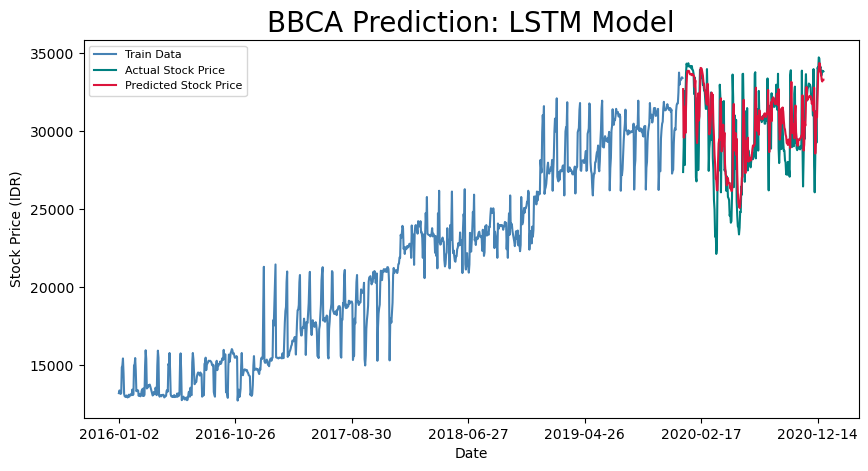

In [31]:
bbca_lstm_train = bbca[:bbca_train_len]
bbca_lstm_valid = bbca[bbca_train_len:]
bbca_lstm_valid['Predictions'] = bbca_pred

plt.figure(figsize = (10,5), dpi = 100)

plt.plot(bbca_lstm_train['Close'], label = 'Train Data', color = 'steelblue')
plt.plot(bbca_lstm_valid['Close'], label = 'Actual Stock Price', color = 'teal')
plt.plot(bbca_lstm_valid['Predictions'], label = 'Predicted Stock Price', color = 'crimson')

plt.title('BBCA Prediction: LSTM Model', size = 20)
plt.xticks(ticks = [0, 200, 400, 600, 800, 1000, 1200])
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper left', fontsize = 8)

plt.savefig('BBCA LSTM.png')
plt.show()

In [32]:
bbca_lstm_valid

,Close,Predictions
Date,,
2020-01-04,27400,32716.17
2020-01-07,29000,29613.52
2020-01-09,32600,29611.06
2020-01-10,27850,31590.22
2020-01-12,31975,29900.48
...,...,...
2020-12-22,33575,33703.15
2020-12-23,33625,33310.38
2020-12-28,33900,33203.90


In [33]:
mse = mean_squared_error(bbca_pred, bbca_lstm_y_test)
print(f'MSE: {mse}')
rmse = math.sqrt(mean_squared_error(bbca_pred, bbca_lstm_y_test))
print(f'RMSE: {rmse}')

MSE: 4204734.6577953305
RMSE: 2050.544966050569


**Manual Tuning**

Saya akan menentukan banyaknya jumlah neuron yang akan digunakan pada LSTM berdasarkan rumus berikut.

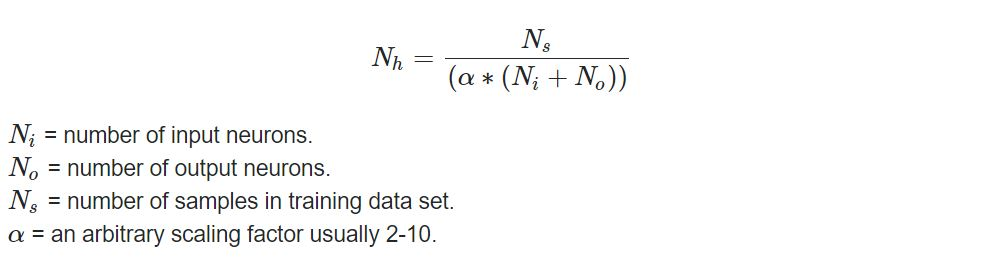

In [34]:
display.Image('./layer_formula.png', width = 600)

Referensi: https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

Dengan parameter:
- Jumlah input adalah 51.
- Jumlah output adalah 1
- Jumlah sampel adalah 969 (sebanyak training data)
- Nilai alpha yang saya gunakan adalah 5

Sehingga diperoleh jumlah layer sebanyak 4 layer.

In [35]:
bbca_lstm_tuned = Sequential()
bbca_lstm_tuned.add(LSTM(4, return_sequences = False, input_shape = (bbca_lstm_x_train.shape[1], 1)))
bbca_lstm_tuned.add(Dropout(0.2))
bbca_lstm_tuned.add(Dense(bbca_lstm_y_train.shape[1]))

bbca_lstm_tuned.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [36]:
bbca_lstm_tuned.fit(bbca_lstm_x_train, bbca_lstm_y_train, batch_size = 32, epochs = 100)

Epoch 1/100
29/29 [==============================] - 5s 32ms/step - loss: 0.3453
Epoch 2/100
29/29 [==============================] - 1s 31ms/step - loss: 0.1522
Epoch 3/100
29/29 [==============================] - 1s 39ms/step - loss: 0.0758
Epoch 4/100
29/29 [==============================] - 1s 38ms/step - loss: 0.0548
Epoch 5/100
29/29 [==============================] - 1s 39ms/step - loss: 0.0512
Epoch 6/100
29/29 [==============================] - 1s 38ms/step - loss: 0.0509
Epoch 7/100
29/29 [==============================] - 1s 30ms/step - loss: 0.0417
Epoch 8/100
29/29 [==============================] - 1s 34ms/step - loss: 0.0324
Epoch 9/100
29/29 [==============================] - 2s 55ms/step - loss: 0.0350
Epoch 10/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0253
Epoch 11/100
29/29 [==============================] - 1s 33ms/step - loss: 0.0324
Epoch 12/100
29/29 [==============================] - 2s 53ms/step - loss: 0.0266
Epoch 13/100
29/29 [=====

In [37]:
bbca_pred_tuned = bbca_lstm_tuned.predict(bbca_lstm_x_test)
bbca_pred_tuned = scaler.inverse_transform(bbca_pred_tuned)

**Model Evaluation**

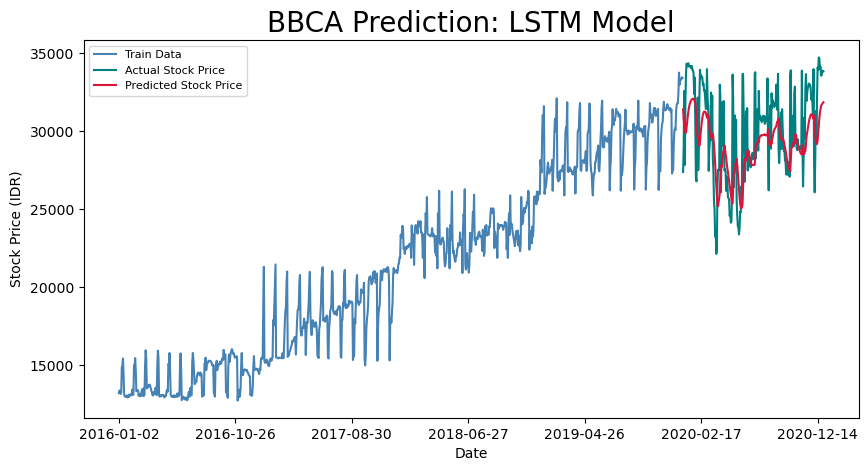

In [38]:
bbca_lstm_train = bbca[:bbca_train_len]
bbca_lstm_valid = bbca[bbca_train_len:]
bbca_lstm_valid['Predictions'] = bbca_pred_tuned

plt.figure(figsize = (10,5), dpi = 100)

plt.plot(bbca_lstm_train['Close'], label = 'Train Data', color = 'steelblue')
plt.plot(bbca_lstm_valid['Close'], label = 'Actual Stock Price', color = 'teal')
plt.plot(bbca_lstm_valid['Predictions'], label = 'Predicted Stock Price', color = 'crimson')

plt.title('BBCA Prediction: LSTM Model', size = 20)
plt.xticks(ticks = [0, 200, 400, 600, 800, 1000, 1200])
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper left', fontsize = 8)

plt.show()

In [39]:
mse_tuned = mean_squared_error(bbca_pred_tuned, bbca_lstm_y_test)
print(f'MSE: {mse_tuned}')
rmse_tuned = math.sqrt(mean_squared_error(bbca_pred_tuned, bbca_lstm_y_test))
print(f'RMSE: {rmse_tuned}')

MSE: 6269557.253900102
RMSE: 2503.90839566868


**Result Comparison**

In [40]:
pd.set_option('display.float_format', '{:.2f}'.format)
lstm_compare = {'Evaluation Method': ['MSE', 'RMSE'], 'Random Parameter' : [mse, rmse], 'Manual Tuning' : [mse_tuned, rmse_tuned]}
pd.DataFrame(lstm_compare)

,Evaluation Method,Random Parameter,Manual Tuning
0,MSE,4204734.66,6269557.25
1,RMSE,2050.54,2503.91


In [41]:
rmse_ratio = rmse/ bbca_lstm_valid['Close'].mean()
rmse_tuned_ratio = rmse_tuned/ bbca_lstm_valid['Close'].mean()

In [42]:
print(f'Rasio RMSE (Random Parameter) dengan rata-rata harga saham BBCA (validation price mean) adalah {round(rmse_ratio, 5)}.')
print(f'Rasio RMSE (Manual Tuning) dengan rata-rata harga saham BBCA (validation price mean) adalah {round(rmse_tuned_ratio, 5)}.')

Rasio RMSE (Random Parameter) dengan rata-rata harga saham BBCA (validation price mean) adalah 0.06814.
Rasio RMSE (Manual Tuning) dengan rata-rata harga saham BBCA (validation price mean) adalah 0.0832.


Prediksi harga saham BBCA menggunakan model LSTM dengan random parameter memberikan hasil prediksi yang paling baik.

</br>

### 5. Deployment

Model **LSTM** dengan random parameter memberikan nilai **RMSE yang paling kecil** (nilai prediksinya baik dan mendekati harga saham sesungguhnya). Oleh karena itu, saya akan menyimpan model tersebut untuk digunakan dalam deployment selanjutnya.

In [43]:
bbca_lstm.save('bbca_lstm_model.h5')

**Forecasting Future Prices**

In [44]:
bbca_lstm = load_model('bbca_lstm_model.h5')

In [45]:
bbca_scaled.shape

(1211, 1)

In [46]:
# Predict List

fit_new = bbca_scaled[len(bbca_scaled) - 51:, :]
steps = 246

new_data = []
new_result = []

for i in range(steps):
    new_data.clear()
    new_data.append(fit_new[i:])

    new_data = np.array(new_data)
    new_data = np.reshape(new_data, (new_data.shape[0], new_data.shape[1], 1))

    result = bbca_lstm.predict(new_data)
    new_result.append(scaler.inverse_transform(result))
    fit_new = np.append(fit_new, result)
    new_data = list(new_data)

Saya memilih _steps_ sebesar 246, sesuai dengan banyaknya hari perdagangan bursa di Indonesia untuk tahun 2021.

In [79]:
new_result = np.array(new_result)
new_result = np.reshape(new_result, (new_result.shape[0]))
new_result = pd.DataFrame(new_result)

In [80]:
new_result.to_csv('prediction_bbca.csv')

In [81]:
new = pd.DataFrame(bbca_array)
new = new.append(new_result, ignore_index = True)
new.columns = ['Price']

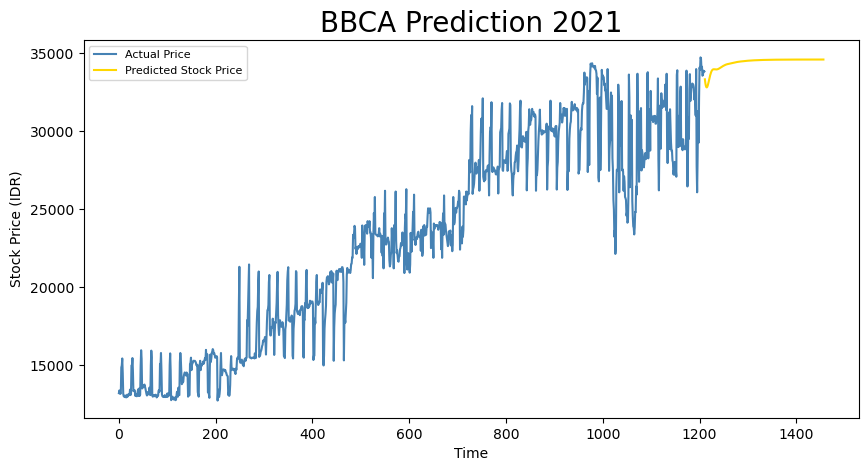

In [59]:
plt.figure(figsize = (10,5), dpi = 100)

plt.plot(new[:len(bbca)], label = 'Actual Price', color = 'steelblue')
plt.plot(new[len(bbca) : ], label = 'Predicted Stock Price', color = 'gold')

plt.title('BBCA Prediction 2021', size = 20)
plt.xlabel('Time')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper left', fontsize = 8)

plt.show()

Data yang saya gunakan untuk memprediksi harga saham 2021 merupakan nilai prediksi dari model LSTM yang digunakan berulang-ulang (tidak menambahkan data baru).

Hasil percobaan yang saya dapatkan adalah, semakin besar nilai _steps_ maka hasil prediksi akan konvergen ke suatu nilai tertentu. Hal ini merupakan kelemahan dari model LSTM. Walaupun LSTM dapat memodelkan pergerakan harga saham dengan sangat baik (dibandingkan dengan model ARIMA), namun model LSTM kurang ideal apabila kita ingin memprediksi harga saham jangka panjang (nilai _steps_ besar). Pergerakan harga saham sesungguhnya kurang tercerminkan, namun kita masih bisa memprediksi trend pergerakan harga saham.

Untuk menghasilkan prediksi yang akurat menggunakan LSTM, maka data yang digunakan untuk prediksi harus selalu diperbaharui dan _steps_ yang ditentukan tidak boleh terlalu besar.

In [74]:
buy_price = new['Price'][1]
price_5 = new['Price'][len(bbca) + 5]
price_30 = new['Price'][len(bbca) + 30]
price_60 = new['Price'][len(bbca) + 60]
price_90 = new['Price'][len(bbca) + 90]
price_120 = new['Price'][len(bbca) + 120]
price_end = new['Price'].iloc[-1]

In [77]:
pd.set_option('display.float_format', '{:.2f}'.format)
future_prices = {'Description': ['Buy Price', 'Prediction 2021 (1 Week)', 'Prediction 2021 (1 Month)', 'Prediction 2021 (2 Months)', 'Prediction 2021 (3 Months)', 'Prediction 2021 (4 Months)', 'Prediction 2021 (End of 2021)'],
                'Price' : [buy_price, price_5, price_30, price_60, price_90, price_120, price_end],
                'Return': ['-', (price_5-buy_price)/ buy_price, (price_30-buy_price)/ buy_price, (price_60-buy_price)/ buy_price, (price_90-buy_price)/ buy_price, (price_120-buy_price)/ buy_price, (price_end-buy_price)/ buy_price]}
pd.DataFrame(future_prices)

,Description,Price,Return
0,Buy Price,13400.00,-
1,Prediction 2021 (1 Week),32866.02,1.45
2,Prediction 2021 (1 Month),34045.98,1.54
3,Prediction 2021 (2 Months),34408.91,1.57
4,Prediction 2021 (3 Months),34538.27,1.58
5,Prediction 2021 (4 Months),34585.06,1.58
6,Prediction 2021 (End of 2021),34612.32,1.58


Terlihat bahwa harga saham akan konvergen ke IDR 34600, dengan rasio return mencapai 1.58 (hampir dua kali lipat dari harga beli di tahun 2016).